In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

data = pd.read_csv('/content/drive/MyDrive/Team7/ForwardKeys_data.csv')

data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data.set_index('Datetime', inplace=True)

# Filter data for 8 am
data_8am = data[data['Time'] == '8:00'].copy()
target_variable = 'Visitors in Blue Lagoon'

# create 15 lag features
for i in range(1, 16):
    data_8am[f'lag_{i}'] = data_8am[target_variable].shift(i)

# Drop rows with nan values
data_8am.dropna(inplace=True)

# Prepare feature matrix X and target y
X = data_8am[[f'lag_{i}' for i in range(1, 16)]]
y = data_8am[target_variable]

# Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Predict number of visitors
predictions = []
current_features = list(X.iloc[-1])

for _ in range(15):
    current_prediction = model.predict([current_features])[0]
    predictions.append(current_prediction)
    current_features = current_features[1:] + [current_prediction]

forecast_df = pd.DataFrame(predictions, columns=[target_variable])
forecast_df.index = pd.date_range(start=data_8am.index[-1] + pd.Timedelta(days=1), periods=15, freq='D')

print(forecast_df)


                     Visitors in Blue Lagoon
2024-02-16 08:00:00                  4796.71
2024-02-17 08:00:00                  3648.84
2024-02-18 08:00:00                  4004.26
2024-02-19 08:00:00                  4078.09
2024-02-20 08:00:00                  4378.88
2024-02-21 08:00:00                  3884.63
2024-02-22 08:00:00                  4227.67
2024-02-23 08:00:00                  3802.24
2024-02-24 08:00:00                  4261.66
2024-02-25 08:00:00                  4260.75
2024-02-26 08:00:00                  4408.35
2024-02-27 08:00:00                  4145.00
2024-02-28 08:00:00                  4364.85
2024-02-29 08:00:00                  4060.38
2024-03-01 08:00:00                  4312.02


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does

In [ ]:
!pip install xgboost

Predicted visitors for 2024-02-16 at 8:00 AM: 4190
Predicted visitors for 2024-02-17 at 8:00 AM: 4200
Predicted visitors for 2024-02-18 at 8:00 AM: 4195
Predicted visitors for 2024-02-19 at 8:00 AM: 4195
Predicted visitors for 2024-02-20 at 8:00 AM: 4197
Predicted visitors for 2024-02-21 at 8:00 AM: 4185
Predicted visitors for 2024-02-22 at 8:00 AM: 4163
Predicted visitors for 2024-02-23 at 8:00 AM: 4190
Predicted visitors for 2024-02-24 at 8:00 AM: 4200
Predicted visitors for 2024-02-25 at 8:00 AM: 4195


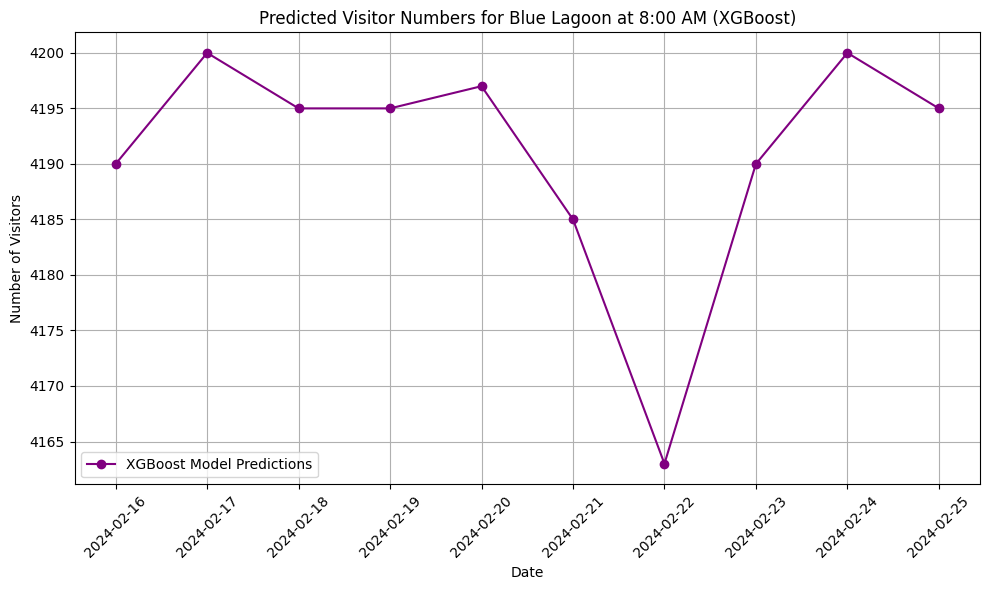

In [ ]:
# Filter data for 8:00AM
data['Date'] = pd.to_datetime(data['Date'])
data_8am = data[data['Time'] == '8:00'].copy()

data_8am['DayOfWeek'] = data_8am['Date'].dt.dayofweek  # 0: Monday, 6: Sunday
data_8am['Month'] = data_8am['Date'].dt.month
data_8am['Year'] = data_8am['Date'].dt.year

X = data_8am[['DayOfWeek', 'Month', 'Year', 'Average Age - Blue Lagoon']]
y = data_8am['Visitors in Blue Lagoon']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#train XgBoost
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
model.fit(X_train_scaled, y_train)

# Predict for 10 days
max_date = data_8am['Date'].max()
future_dates = [max_date + timedelta(days=x) for x in range(1, 11)]
future_data = pd.DataFrame({'Date': future_dates})
future_data['DayOfWeek'] = future_data['Date'].dt.dayofweek
future_data['Month'] = future_data['Date'].dt.month
future_data['Year'] = future_data['Date'].dt.year
future_data['Average Age - Blue Lagoon'] = data_8am['Average Age - Blue Lagoon'].mean()

future_features = future_data[['DayOfWeek', 'Month', 'Year', 'Average Age - Blue Lagoon']]
future_features_scaled = scaler.transform(future_features)

#predict
predictions = model.predict(future_features_scaled)

for date, pred in zip(future_dates, predictions):
    print(f"Predicted visitors for {date.strftime('%Y-%m-%d')} at 8:00 AM: {int(pred)}")

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

predictions_xgboost = [4190, 4200, 4195, 4195, 4197, 4185, 4163, 4190, 4200, 4195]
future_dates = [datetime(2024, 2, 16) + timedelta(days=x) for x in range(10)]

df_xgboost_predictions = pd.DataFrame({
    'Date': future_dates,
    'Predicted Visitors': predictions_xgboost
})

# viz
plt.figure(figsize=(10, 6))
plt.plot(df_xgboost_predictions['Date'], df_xgboost_predictions['Predicted Visitors'], marker='o', linestyle='-', color='purple', label='XGBoost Model Predictions')
plt.title('Predicted Visitor Numbers for Blue Lagoon at 8:00 AM (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Number of Visitors')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-4-691be7be332f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_8am['DayOfWeek'] = data_8am['Date'].dt.dayofweek
<ipython-input-4-691be7be332f>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_8am['Month'] = data_8am['Date'].dt.month
<ipython-input-4-691be7be332f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

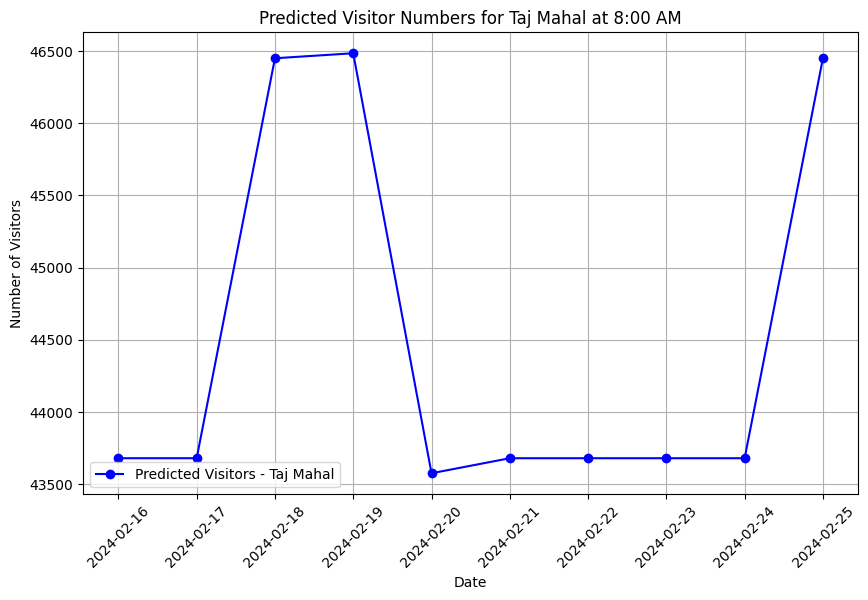

RMSE for Train Data: 12105.918110897284
RMSE for Test Data: 13233.157587142086
R-squared value for Train Data: 0.18740626544908956
R-squared value for Test Data: 0.13777526807515106


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/ForwardKeys_data.csv')
# filter 8 am slots
data['Date'] = pd.to_datetime(data['Date'])
data_8am = data[data['Time'] == '8:00']

# Create features based on the 'Date' column
data_8am['DayOfWeek'] = data_8am['Date'].dt.dayofweek
data_8am['Month'] = data_8am['Date'].dt.month
data_8am['Year'] = data_8am['Date'].dt.year

#dataset for tajmahal
X = data_8am[['DayOfWeek', 'Month', 'Year', 'Average Age - Taj Mahal']]
y = data_8am['Visitors in Taj Mahal']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                         max_depth=5, alpha=10, n_estimators=10)
model.fit(X_train_scaled, y_train)

# predict the next 10 days
max_date = data_8am['Date'].max()
future_dates = pd.date_range(start=max_date + timedelta(days=1), periods=10)
future_data = pd.DataFrame({
    'DayOfWeek': future_dates.dayofweek,
    'Month': future_dates.month,
    'Year': future_dates.year,
    'Average Age - Taj Mahal': X['Average Age - Taj Mahal'].mean()
})

# Scale future features
future_features_scaled = scaler.transform(future_data)

predictions = model.predict(future_features_scaled)

#viz
plt.figure(figsize=(10, 6))
plt.plot(future_dates, predictions, marker='o', linestyle='-', color='blue', label='Predicted Visitors - Taj Mahal')
plt.title('Predicted Visitor Numbers for Taj Mahal at 8:00 AM')
plt.xlabel('Date')
plt.ylabel('Number of Visitors')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import mean_squared_error, r2_score

# # Predicting on train and test data
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# RMSE
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

print("RMSE for Train Data:", rmse_train)
print("RMSE for Test Data:", rmse_test)

# R-square
r2_value_train = r2_score(y_train, y_pred_train)
r2_value_test = r2_score(y_test, y_pred_test)

print("R-squared value for Train Data:", r2_value_train)
print("R-squared value for Test Data:", r2_value_test)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
from datetime import datetime, timedelta

# Prepare the features and target
X = data_8am[['DayOfWeek', 'Month', 'Year', 'Average Age - Blue Lagoon']]
y = data_8am['Visitors in Blue Lagoon']

# split data
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#split the training set for training andvalidation for base model
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# base learners
base_learners = [
    ('dt', DecisionTreeRegressor(random_state=42)),
    ('knn', KNeighborsRegressor()),
    ('svr', SVR(C=1.0, epsilon=0.2))
]

# stacking ensbl
stack_reg = StackingRegressor(
    estimators=base_learners, final_estimator=LinearRegression(), cv=5
)

# fit model
stack_reg.fit(X_train_scaled, y_train)

# predict for 10 days
max_date = data_8am['Date'].max()
future_dates = [max_date + timedelta(days=x) for x in range(1, 11)]
future_data = pd.DataFrame({'Date': future_dates})
future_data['DayOfWeek'] = future_data['Date'].dt.dayofweek
future_data['Month'] = future_data['Date'].dt.month
future_data['Year'] = future_data['Date'].dt.year
future_data['Average Age - Blue Lagoon'] = data_8am['Average Age - Blue Lagoon'].mean()

#features for prediction
future_features = future_data[['DayOfWeek', 'Month', 'Year', 'Average Age - Blue Lagoon']]
future_features_scaled = scaler.transform(future_features)

# predict
predictions = stack_reg.predict(future_features_scaled)
for date, pred in zip(future_dates, predictions):
    print(f"Predicted visitors for {date.strftime('%Y-%m-%d')} at 8:00 AM: {int(pred)}")


Predicted visitors for 2024-02-16 at 8:00 AM: 4216
Predicted visitors for 2024-02-17 at 8:00 AM: 4210
Predicted visitors for 2024-02-18 at 8:00 AM: 4210
Predicted visitors for 2024-02-19 at 8:00 AM: 4220
Predicted visitors for 2024-02-20 at 8:00 AM: 4221
Predicted visitors for 2024-02-21 at 8:00 AM: 4225
Predicted visitors for 2024-02-22 at 8:00 AM: 4225
Predicted visitors for 2024-02-23 at 8:00 AM: 4216
Predicted visitors for 2024-02-24 at 8:00 AM: 4210
Predicted visitors for 2024-02-25 at 8:00 AM: 4210


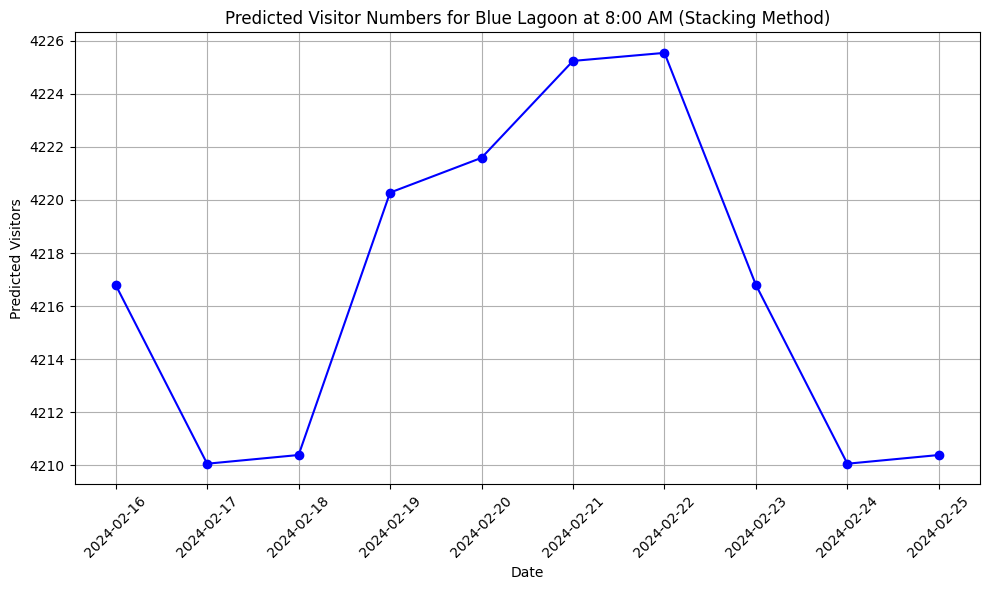

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from datetime import datetime, timedelta



# Prepare the features and target
X = data_8am[['DayOfWeek', 'Month', 'Year', 'Average Age - Blue Lagoon']]
y = data_8am['Visitors in Blue Lagoon']

# split data
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split training set for training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# scale feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# base learners
base_learners = [
    ('dt', DecisionTreeRegressor(random_state=42)),
    ('knn', KNeighborsRegressor()),
    ('svr', SVR(C=1.0, epsilon=0.2))
]

# stacking ensemb
stack_reg = StackingRegressor(
    estimators=base_learners, final_estimator=LinearRegression(), cv=5
)

# fit model
stack_reg.fit(X_train_scaled, y_train)

# Predict for the next 10 days
max_date = data_8am['Date'].max()
future_dates = [max_date + timedelta(days=x) for x in range(1, 11)]
future_data = pd.DataFrame({'Date': future_dates})
future_data['DayOfWeek'] = future_data['Date'].dt.dayofweek
future_data['Month'] = future_data['Date'].dt.month
future_data['Year'] = future_data['Date'].dt.year
future_data['Average Age - Blue Lagoon'] = data_8am['Average Age - Blue Lagoon'].mean()

# features for prediction
future_features = future_data[['DayOfWeek', 'Month', 'Year', 'Average Age - Blue Lagoon']]
future_features_scaled = scaler.transform(future_features)

#predict
predictions = stack_reg.predict(future_features_scaled)

# viz
plt.fiVisualizing the predictionse(figsize=(10, 6))
plt.plot(future_dates, predictions, marker='o', linestyle='-', color='b')
plt.title('Predicted Visitor Numbers for Blue Lagoon at 8:00 AM (Stacking Method)')
plt.xlabel('Date')
plt.ylabel('Predicted Visitors')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
from datetime import datetime, timedelta

X = data_8am[['DayOfWeek', 'Month', 'Year', 'Average Age - Taj Mahal']]
y = data_8am['Visitors in Taj Mahal']

# split data
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split training set for training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# scale feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# base learners
base_learners = [
    ('dt', DecisionTreeRegressor(random_state=42)),
    ('knn', KNeighborsRegressor()),
    ('svr', SVR(C=1.0, epsilon=0.2))
]

# stacking ensemb
stack_reg = StackingRegressor(
    estimators=base_learners, final_estimator=LinearRegression(), cv=5
)

# fit model
stack_reg.fit(X_train_scaled, y_train)

predict for 10 days
max_date = data_8am['Date'].max()
future_dates = [max_date + timedelta(days=x) for x in range(1, 11)]
future_data = pd.DataFrame({'Date': future_dates})
future_data['DayOfWeek'] = future_data['Date'].dt.dayofweek
future_data['Month'] = future_data['Date'].dt.month
future_data['Year'] = future_data['Date'].dt.year
future_data['Average Age - Taj Mahal'] = data_8am['Average Age - Taj Mahal'].mean()

# features for prediction
future_features = future_data[['DayOfWeek', 'Month', 'Year', 'Average Age - Taj Mahal']]
future_features_scaled = scaler.transform(future_features)

#predict
predictions = stack_reg.predict(future_features_scaled)

# final prediction
for date, pred in zip(future_dates, predictions):
    print(f"Predicted visitors for {date.strftime('%Y-%m-%d')} at 8:00 AM: {int(pred)}")


Predicted visitors for 2024-02-16 at 8:00 AM: 39157
Predicted visitors for 2024-02-17 at 8:00 AM: 40237
Predicted visitors for 2024-02-18 at 8:00 AM: 61656
Predicted visitors for 2024-02-19 at 8:00 AM: 59524
Predicted visitors for 2024-02-20 at 8:00 AM: 33036
Predicted visitors for 2024-02-21 at 8:00 AM: 40512
Predicted visitors for 2024-02-22 at 8:00 AM: 36183
Predicted visitors for 2024-02-23 at 8:00 AM: 39157
Predicted visitors for 2024-02-24 at 8:00 AM: 40237
Predicted visitors for 2024-02-25 at 8:00 AM: 61656


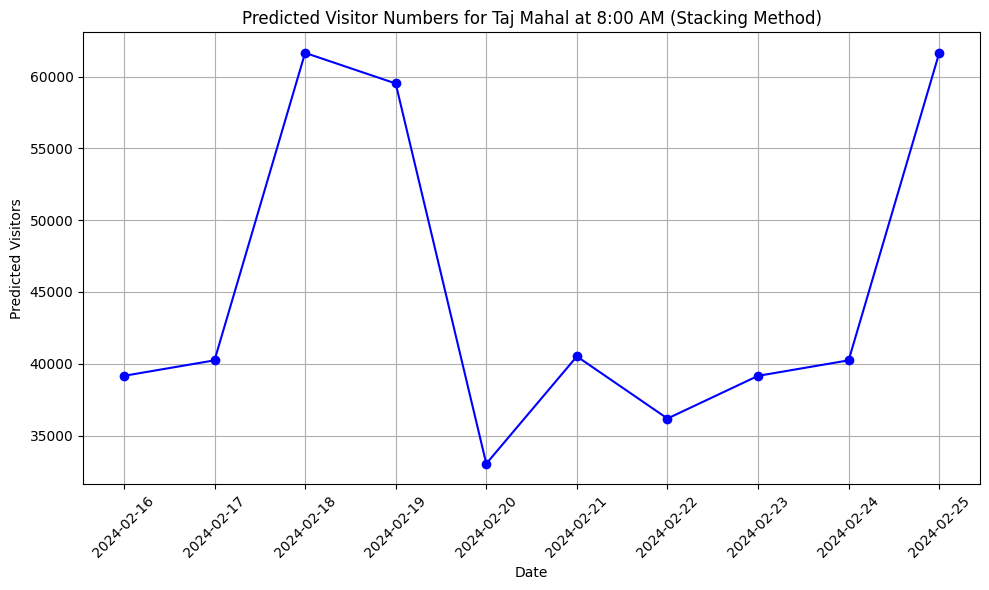

RMSE for Train Data: 1941.1839186565917
RMSE for Test Data: 5973.89915557518
R-squared value for Train Data: 0.9784981669916033
R-squared value for Test Data: 0.8242848201220696


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from datetime import datetime, timedelta

X = data_8am[['DayOfWeek', 'Month', 'Year', 'Average Age - Taj Mahal']]
y = data_8am['Visitors in Taj Mahal']

# split data
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split training set for training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# scale feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# base learners
base_learners = [
    ('dt', DecisionTreeRegressor(random_state=42)),
    ('knn', KNeighborsRegressor()),
    ('svr', SVR(C=1.0, epsilon=0.2))
]

# stacking ensemb
stack_reg = StackingRegressor(
    estimators=base_learners, final_estimator=LinearRegression(), cv=5
)

# fit model
stack_reg.fit(X_train_scaled, y_train)

predict for 10 days
max_date = data_8am['Date'].max()
future_dates = [max_date + timedelta(days=x) for x in range(1, 11)]
future_data = pd.DataFrame({'Date': future_dates})
future_data['DayOfWeek'] = future_data['Date'].dt.dayofweek
future_data['Month'] = future_data['Date'].dt.month
future_data['Year'] = future_data['Date'].dt.year
future_data['Average Age - Taj Mahal'] = data_8am['Average Age - Taj Mahal'].mean()

# features for prediction
future_features = future_data[['DayOfWeek', 'Month', 'Year', 'Average Age - Taj Mahal']]
future_features_scaled = scaler.transform(future_features)

#predict
predictions = stack_reg.predict(future_features_scaled)

# viz
plt.figure(figsize=(10, 6))
plt.plot(future_dates, predictions, marker='o', linestyle='-', color='b')
plt.title('Predicted Visitor Numbers for Taj Mahal at 8:00 AM (Stacking Method)')
plt.xlabel('Date')
plt.ylabel('Predicted Visitors')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

plt.show()

# # Predicting on train and test data
y_pred_train = stack_reg.predict(X_train_scaled)
y_pred_test = stack_reg.predict(X_test_scaled)

# Rmse
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

print("RMSE for Train Data:", rmse_train)
print("RMSE for Test Data:", rmse_test)

# R-square
r2_value_train = r2_score(y_train, y_pred_train)
r2_value_test = r2_score(y_test, y_pred_test)

print("R-squared value for Train Data:", r2_value_train)
print("R-squared value for Test Data:", r2_value_test)


<ipython-input-11-15cc7924e125>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_8am['DayOfWeek'] = data_8am['Date'].dt.dayofweek
<ipython-input-11-15cc7924e125>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_8am['Month'] = data_8am['Date'].dt.month
<ipython-input-11-15cc7924e125>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

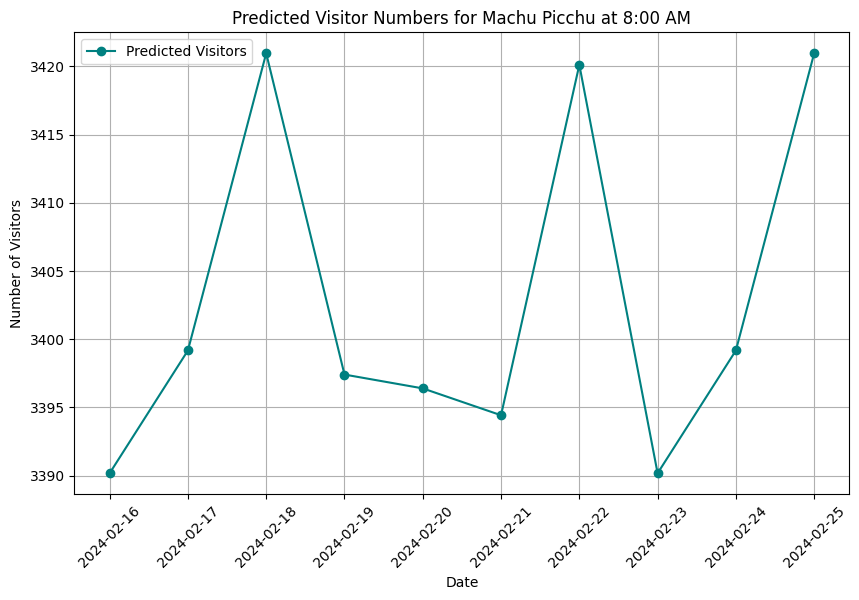

In [ ]:
# Boosting - Machu Pichu
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from datetime import timedelta, datetime
import matplotlib.pyplot as plt

data['Date'] = pd.to_datetime(data['Date'])

# filter 8 am slots
data_8am = data[data['Time'] == '8:00']
data_8am['DayOfWeek'] = data_8am['Date'].dt.dayofweek
data_8am['Month'] = data_8am['Date'].dt.month
data_8am['Year'] = data_8am['Date'].dt.year

# Selecting features and target for Machu Picchu
X = data_8am[['DayOfWeek', 'Month', 'Year', 'Average Age - Machu Picchu']]
y = data_8am['Visitors in Machu Picchu']

# split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# training XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                         max_depth=5, alpha=10, n_estimators=10)
model.fit(X_train_scaled, y_train)

# predict the next 10 days
max_date = data_8am['Date'].max()
future_dates = pd.date_range(start=max_date + timedelta(days=1), periods=10, freq='D')
future_data = pd.DataFrame({
    'Date': future_dates,
    'DayOfWeek': future_dates.dayofweek,
    'Month': future_dates.month,
    'Year': future_dates.year
})
future_data['Average Age - Machu Picchu'] = data_8am['Average Age - Machu Picchu'].mean()

# Scale future features
future_features_scaled = scaler.transform(future_data[['DayOfWeek', 'Month', 'Year', 'Average Age - Machu Picchu']])

# predict visitors
predictions = model.predict(future_features_scaled)

# viz
plt.figure(figsize=(10, 6))
plt.plot(future_dates, predictions, marker='o', linestyle='-', color='teal', label='Predicted Visitors')
plt.title('Predicted Visitor Numbers for Machu Picchu at 8:00 AM')
plt.xlabel('Date')
plt.ylabel('Number of Visitors')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()



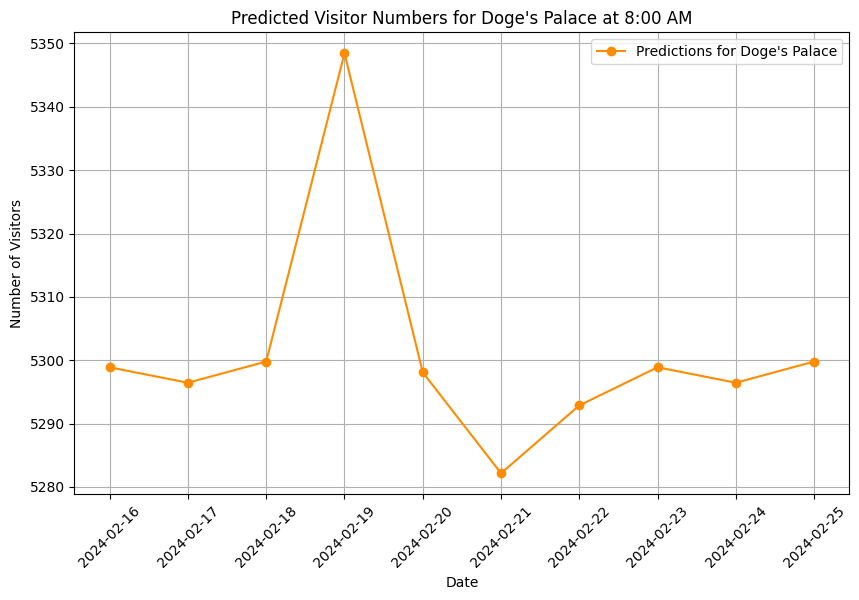

In [ ]:
# Boosting - Doge palace
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Convert 'Date' to datetime and filter for 8:00 AM slots, if not already done
data['Date'] = pd.to_datetime(data['Date'])
data_8am = data[data['Time'] == '8:00'].copy()

# Extract day of the week, month, and year as separate features
data_8am['DayOfWeek'] = data_8am['Date'].dt.dayofweek
data_8am['Month'] = data_8am['Date'].dt.month
data_8am['Year'] = data_8am['Date'].dt.year

# Prepare the dataset for Doge's Palace
X_doge = data_8am[['DayOfWeek', 'Month', 'Year', 'Average Age - Doge\'s Palace']]
y_doge = data_8am['Visitors in Doge\'s Palace']

# split dataset into training and testing sets
X_train_doge, X_test_doge, y_train_doge, y_test_doge = train_test_split(X_doge, y_doge, test_size=0.2, random_state=42)

# scale feature
scaler_doge = StandardScaler()
X_train_scaled_doge = scaler_doge.fit_transform(X_train_doge)
X_test_scaled_doge = scaler_doge.transform(X_test_doge)

# Train the XGBoost model
model_doge = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                              max_depth=5, alpha=10, n_estimators=10)
model_doge.fit(X_train_scaled_doge, y_train_doge)

predict for 10 days
max_date = data_8am['Date'].max()
future_dates_doge = pd.date_range(start=max_date + timedelta(days=1), periods=10)
future_data_doge = pd.DataFrame({
    'DayOfWeek': future_dates_doge.dayofweek,
    'Month': future_dates_doge.month,
    'Year': future_dates_doge.year,
    'Average Age - Doge\'s Palace': X_doge['Average Age - Doge\'s Palace'].mean()
})
future_features_scaled_doge = scaler_doge.transform(future_data_doge)

predictions_doge = model_doge.predict(future_features_scaled_doge)

# viz
plt.figure(figsize=(10, 6))
plt.plot(future_dates_doge, predictions_doge, marker='o', linestyle='-', color='darkorange', label='Predictions for Doge\'s Palace')
plt.title('Predicted Visitor Numbers for Doge\'s Palace at 8:00 AM')
plt.xlabel('Date')
plt.ylabel('Number of Visitors')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Assuming your DataFrame 'data' is already loaded
# First, ensure the 'Date' column is in datetime format and filter for 8:00 AM slots
data['Date'] = pd.to_datetime(data['Date'])
data_8am = data[data['Time'] == '8:00']

# Create features based on the 'Date' column
data_8am['DayOfWeek'] = data_8am['Date'].dt.dayofweek
data_8am['Month'] = data_8am['Date'].dt.month
data_8am['Year'] = data_8am['Date'].dt.year

# Prepare the dataset for the Taj Mahal
X = data_8am[['DayOfWeek', 'Month', 'Year', 'Average Age - Taj Mahal']]
y = data_8am['Visitors in Taj Mahal']

# split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the XGBoost model
model_taj = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                         max_depth=5, alpha=10, n_estimators=10)
model_taj.fit(X_train_scaled_taj, y_train_taj)

# predict the next 10 days
max_date = data_8am['Date'].max()
future_dates = pd.date_range(start=max_date + timedelta(days=1), periods=10)
future_data = pd.DataFrame({
    'DayOfWeek': future_dates.dayofweek,
    'Month': future_dates.month,
    'Year': future_dates.year,
    'Average Age - Taj Mahal': X['Average Age - Taj Mahal'].mean()
})

# Scale future features
future_features_scaled = scaler.transform(future_data)

# predict visitors
predictions = model.predict(future_features_scaled)

# viz
plt.figure(figsize=(10, 6))
plt.plot(future_dates, predictions, marker='o', linestyle='-', color='blue', label='Predicted Visitors - Taj Mahal')
plt.title('Predicted Visitor Numbers for Taj Mahal at 8:00 AM')
plt.xlabel('Date')
plt.ylabel('Number of Visitors')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-22-c33fbc5ac927>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_8am['DayOfWeek'] = data_8am['Date'].dt.dayofweek
<ipython-input-22-c33fbc5ac927>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_8am['Month'] = data_8am['Date'].dt.month
<ipython-input-22-c33fbc5ac927>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

ValueError: X has 4 features, but BaggingRegressor is expecting 1 features as input.

<ipython-input-17-610c93418297>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_8am['DayOfWeek'] = data_8am['Date'].dt.dayofweek
<ipython-input-17-610c93418297>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_8am['Month'] = data_8am['Date'].dt.month
<ipython-input-17-610c93418297>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

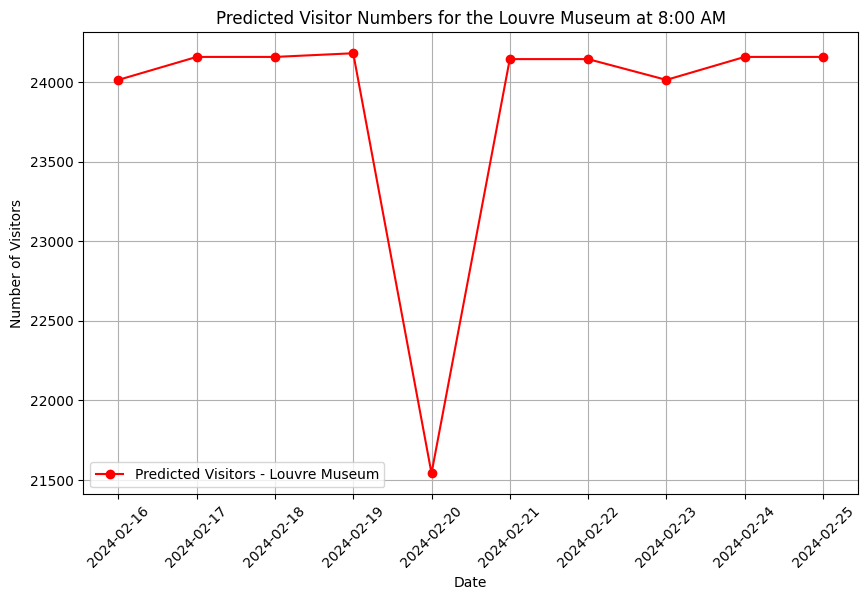

In [ ]:
# Assuming the initial setup is similar and 'data' is your DataFrame
data['Date'] = pd.to_datetime(data['Date'])
data_8am = data[data['Time'] == '8:00']

# Extract day of the week, month, and year as features
data_8am['DayOfWeek'] = data_8am['Date'].dt.dayofweek
data_8am['Month'] = data_8am['Date'].dt.month
data_8am['Year'] = data_8am['Date'].dt.year

# Prepare the dataset for the Louvre Museum
X_louvre = data_8am[['DayOfWeek', 'Month', 'Year', 'Average Age - Louvre Museum']]
y_louvre = data_8am['Visitors in Louvre Museum']

# split dataset into training and testing sets
X_train_louvre, X_test_louvre, y_train_louvre, y_test_louvre = train_test_split(X_louvre, y_louvre, test_size=0.2, random_state=42)

# scale feature
scaler_louvre = StandardScaler()
X_train_scaled_louvre = scaler_louvre.fit_transform(X_train_louvre)
X_test_scaled_louvre = scaler_louvre.transform(X_test_louvre)

# Train the XGBoost model for the Louvre Museum
model_louvre = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                                max_depth=5, alpha=10, n_estimators=10)
model_louvre.fit(X_train_scaled_louvre, y_train_louvre)

# Predicting the next 10 days for the Louvre Museum
max_date = data_8am['Date'].max()
future_dates = pd.date_range(start=max_date + timedelta(days=1), periods=10)
future_data_louvre = pd.DataFrame({
    'DayOfWeek': future_dates.dayofweek,
    'Month': future_dates.month,
    'Year': future_dates.year,
    'Average Age - Louvre Museum': X_louvre['Average Age - Louvre Museum'].mean()
})
future_features_scaled_louvre = scaler_louvre.transform(future_data_louvre)

predictions_louvre = model_louvre.predict(future_features_scaled_louvre)

# viz for the Louvre Museum
plt.figure(figsize=(10, 6))
plt.plot(future_dates, predictions_louvre, marker='o', linestyle='-', color='red', label='Predicted Visitors - Louvre Museum')
plt.title('Predicted Visitor Numbers for the Louvre Museum at 8:00 AM')
plt.xlabel('Date')
plt.ylabel('Number of Visitors')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


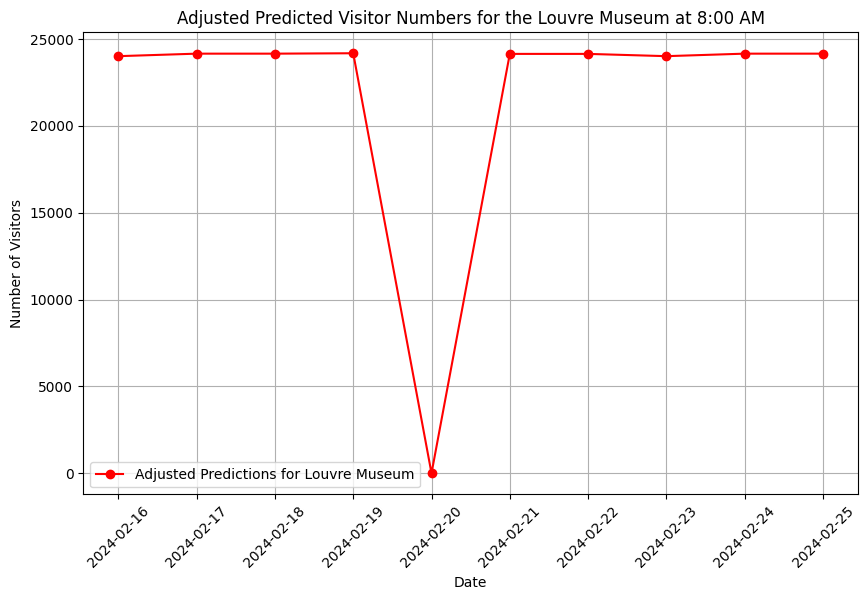

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

max_date = data_8am['Date'].max()
future_dates = pd.date_range(start=max_date + timedelta(days=1), periods=10)
future_weekday = future_dates.dayofweek
predictions_louvre = model_louvre.predict(future_features_scaled_louvre)

# set visitor numbers to 0 for Tuesdays (holiday on tuesday)
adjusted_predictions_louvre = np.where(future_weekday == 1, 0, predictions_louvre)

# viz with Adjusted Predictions
plt.figure(figsize=(10, 6))
plt.plot(future_dates, adjusted_predictions_louvre, marker='o', linestyle='-', color='red', label='Adjusted Predictions for Louvre Museum')
plt.title('Adjusted Predicted Visitor Numbers for the Louvre Museum at 8:00 AM')
plt.xlabel('Date')
plt.ylabel('Number of Visitors')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


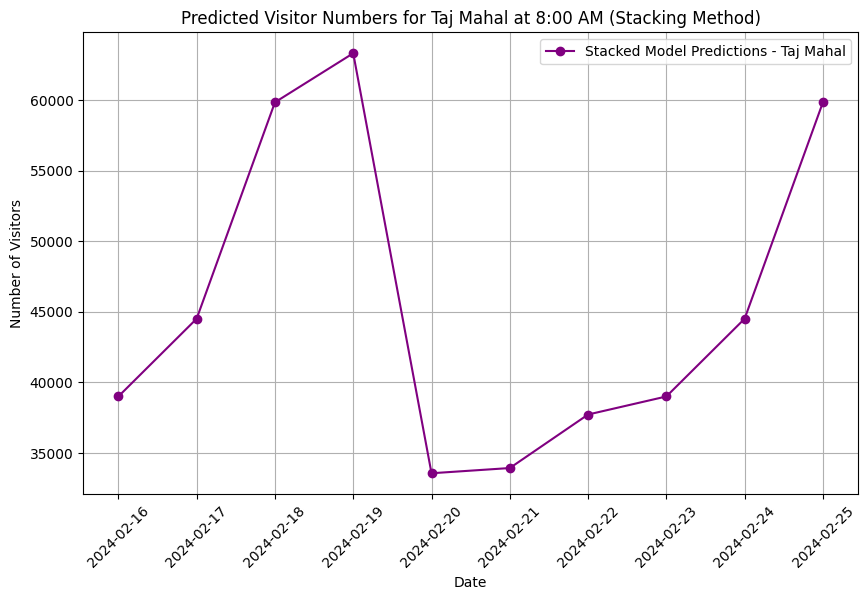

R-squared value: 0.829453612173475


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from datetime import datetime, timedelta

X_taj = data_8am[['DayOfWeek', 'Month', 'Year', 'Average Age - Taj Mahal']]
y_taj = data_8am['Visitors in Taj Mahal']

# split dataset into training and testing sets
X_train_taj, X_test_taj, y_train_taj, y_test_taj = train_test_split(X_taj, y_taj, test_size=0.2, random_state=42)

# scale feature
scaler_taj = StandardScaler()
X_train_scaled_taj = scaler_taj.fit_transform(X_train_taj)
X_test_scaled_taj = scaler_taj.transform(X_test_taj)

# base learners
base_learners = [
    ('dt', DecisionTreeRegressor(random_state=42)),
    ('knn', KNeighborsRegressor()),
    ('svr', SVR(C=1.0, epsilon=0.2))
]

# stacking ensemb
stack_reg_taj = StackingRegressor(
    estimators=base_learners,
    final_estimator=LinearRegression(),
    cv=5
)

# train stacking ensb
stack_reg_taj.fit(X_train_scaled_taj, y_train_taj)

# predict next 10 days
future_dates = pd.date_range(start=max_date + timedelta(days=1), periods=10)
future_data_taj = pd.DataFrame({
    'DayOfWeek': future_dates.dayofweek,
    'Month': future_dates.month,
    'Year': future_dates.year,
    'Average Age - Taj Mahal': X_taj['Average Age - Taj Mahal'].mean()
})
future_features_scaled_taj = scaler_taj.transform(future_data_taj)

predictions_taj = stack_reg_taj.predict(future_features_scaled_taj)

# viz
plt.figure(figsize=(10, 6))
plt.plot(future_dates, predictions_taj, marker='o', linestyle='-', color='purple', label='Stacked Model Predictions - Taj Mahal')
plt.title('Predicted Visitor Numbers for Taj Mahal at 8:00 AM (Stacking Method)')
plt.xlabel('Date')
plt.ylabel('Number of Visitors')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import r2_score

# Predict on test set
y_pred_taj = stack_reg_taj.predict(X_test_scaled_taj)

#R-square
r2_value_taj = r2_score(y_test_taj, y_pred_taj)
print(f"R-squared value: {r2_value_taj}")


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# XGBoost Predictions and Evaluation
xgb_predictions_taj = model_taj.predict(X_test_scaled_taj)
xgb_rmse = sqrt(mean_squared_error(y_test_taj, xgb_predictions_taj))

# Stacking Predictions and Evaluation
stacking_predictions_taj = stack_reg_taj.predict(X_test_scaled_taj)
stacking_rmse = sqrt(mean_squared_error(y_test_taj, stacking_predictions_taj))

# Display RMSE for both models
print(f"XGBoost RMSE for Taj Mahal: {xgb_rmse:.2f}")
print(f"Stacking RMSE for Taj Mahal: {stacking_rmse:.2f}")


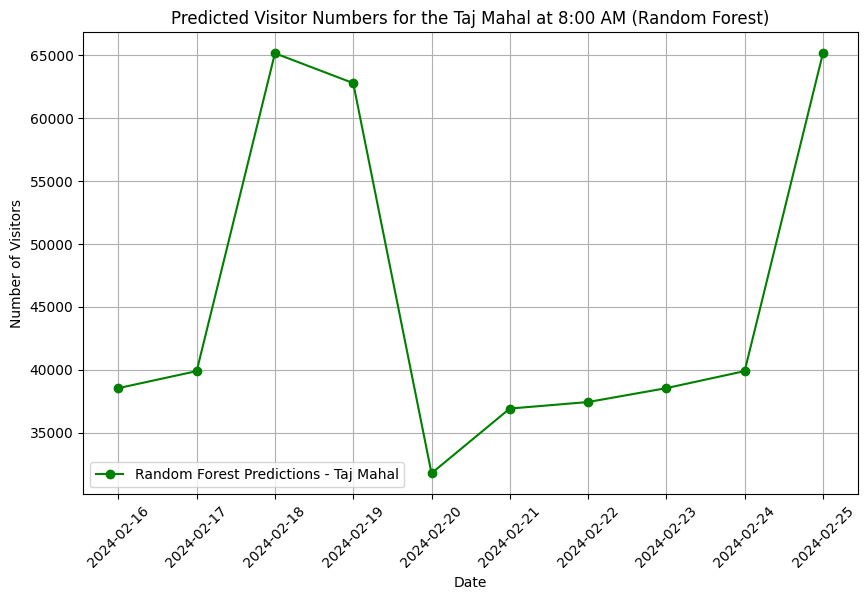

R-squared value: 0.8767020035395943


In [ ]:
data_8am['DayOfWeek'] = data_8am['Date'].dt.dayofweek
data_8am['Month'] = data_8am['Date'].dt.month
data_8am['Year'] = data_8am['Date'].dt.year

# Prepare the dataset for the Taj Mahal
X = data_8am[['DayOfWeek', 'Month', 'Year', 'Average Age - Taj Mahal']]
y = data_8am['Visitors in Taj Mahal']

# split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# predict visitors for 10 days
future_dates = pd.date_range(start=max_date + timedelta(days=1), periods=10)
future_data = pd.DataFrame({
    'DayOfWeek': future_dates.dayofweek,
    'Month': future_dates.month,
    'Year': future_dates.year,
    'Average Age - Taj Mahal': X['Average Age - Taj Mahal'].mean()
})
future_features_scaled = scaler.transform(future_data)  # Apply same scaling as training set

predictions_rf = rf_model.predict(future_features_scaled)

# viz
plt.figure(figsize=(10, 6))
plt.plot(future_dates, predictions_rf, marker='o', linestyle='-', color='green', label='Random Forest Predictions - Taj Mahal')
plt.title('Predicted Visitor Numbers for the Taj Mahal at 8:00 AM (Random Forest)')
plt.xlabel('Date')
plt.ylabel('Number of Visitors')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Predicting on the test set
y_pred = rf_model.predict(X_test_scaled)

#R-square
from sklearn.metrics import r2_score
r2_value = r2_score(y_test, y_pred)
print(f"R-squared value: {r2_value}")



In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Random Forest RMSE
predictions_test_rf = rf_model.predict(X_test_scaled)
rf_rmse = sqrt(mean_squared_error(y_test, predictions_test_rf))
print(f"Random Forest RMSE for Taj Mahal: {rf_rmse:.2f}")

# XGBoost RMSE
predictions_test_xgb = model_taj.predict(X_test_scaled)
xgb_rmse = sqrt(mean_squared_error(y_test, predictions_test_xgb))
print(f"XGBoost RMSE for Taj Mahal: {xgb_rmse:.2f}")

# Stacking RMSE
predictions_test_stack = stack_reg_taj.predict(X_test_scaled)
stack_rmse = sqrt(mean_squared_error(y_test, predictions_test_stack))
print(f"Stacking RMSE for Taj Mahal: {stack_rmse:.2f}")


In [ ]:
import numpy as np

def calculate_bias_variance(predictions, targets):

    expected_prediction = np.mean(predictions, axis=0
    # Calculate Bias
    bias = np.mean((expected_prediction - targets)**2)

    # Calculate Variance
    variance = np.mean(np.var(predictions, axis=0))
    return bias, variance

predictions = np.array([
    [1.2, 1.3, 1.4, 1.5],  # Predictions from Model 1
    [1.0, 1.1, 1.3, 1.4],  # Predictions from Model 2
    [1.4, 1.5, 1.6, 1.7]   # Predictions from Model 3
])

targets = np.array([1.0, 1.2, 1.4, 1.6])  # Actual target values

bias, variance = calculate_bias_variance(predictions, targets)
print("Bias:", bias)
print("Variance:", variance)

Bias: 0.0138888888888889
Variance: 0.02111111111111111


In [ ]:
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
import numpy as np

n_iterations = 100

# initialize lists to store predictions
predictions_rf = []
predictions_xgb = []
predictions_taj = []  # Corrected variable name

# perform bootstrap iterations
for i in range(n_iterations):
   #resample training set
    X_train_resampled, y_train_resampled = resample(X_train_scaled, y_train, random_state=i)
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_resampled, y_train_resampled)

    # train XGBoost model
    model_taj = XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                         max_depth=5, alpha=10, n_estimators=10)
    model_taj.fit(X_train_resampled, y_train_resampled)

    # train Stacking model
    stack_reg_taj = StackingRegressor(
        estimators=[('rf', rf_model), ('xgb', model_taj)],
        final_estimator=LinearRegression()
    )
    stack_reg_taj.fit(X_train_resampled, y_train_resampled)

    #predict on test set for each model
    predictions_rf.append(rf_model.predict(X_test_scaled))
    predictions_xgb.append(model_taj.predict(X_test_scaled))
    predictions_taj.append(stack_reg_taj.predict(X_test_scaled))

# predictions to arrays
predictions_rf = np.array(predictions_rf)
predictions_xgb = np.array(predictions_xgb)
predictions_taj = np.array(predictions_taj)

# bias and variance
bias_rf = np.mean((y_test.values - np.mean(predictions_rf, axis=0))**2)
bias_xgb = np.mean((y_test.values - np.mean(predictions_xgb, axis=0))**2)
bias_stack = np.mean((y_test.values - np.mean(predictions_taj, axis=0))**2)

variance_rf = np.mean(np.var(predictions_rf, axis=0))
variance_xgb = np.mean(np.var(predictions_xgb, axis=0))
variance_stack = np.mean(np.var(predictions_taj, axis=0))

print("Bias and Variance for Random Forest:")
print(f"Bias: {bias_rf:.2f}")
print(f"Variance: {variance_rf:.2f}")
print()
print("Bias and Variance for XGBoost:")
print(f"Bias: {bias_xgb:.2f}")
print(f"Variance: {variance_xgb:.2f}")
print()
print("Bias and Variance for Stacking:")
print(f"Bias: {bias_stack:.2f}")
print(f"Variance: {variance_stack:.2f}")

NameError: name 'X_train_scaled' is not defined

In [ ]:
data_processed = data.dropna()
data_processed = data_processed.drop(['Unnamed: 0', 'Location'], axis=1)

# Filter the data for February 16th, 2024
date_to_predict = datetime(2024, 2, 16)
data_filtered = data_processed[data_processed['Date'] == date_to_predict]

# Prepare the dataset
X = data_filtered.drop(['Average Age'], axis=1)  # Features
y = data_filtered['Average Age']  # Target variable

# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standarized the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the number of bootstrap iterations
n_iterations = 100

# make lists to store predictions
predictions = []

# bootstrap iterations
for i in range(n_iterations):
    # resample
    X_resampled, y_resampled = resample(X_train_scaled, y_train, random_state=i)

    # train the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_resampled, y_resampled)

    #predict for February 16th, 2024
    y_pred = rf_model.predict(X_test_scaled)

    # Store predictions
    predictions.append(y_pred)

# convert predictions to array
predictions = np.array(predictions)

#mean prediction
mean_predictions = np.mean(predictions, axis=0)

# print predicted average age for each time slot on February 16th, 2024
for i, prediction in enumerate(mean_predictions):
    print(f"Predicted average age for time slot {i+1}: {prediction:.2f}")


KeyError: "['Unnamed: 0', 'Location'] not found in axis"

In [ ]:
sample_data_size = X_train.shape[0]
print("Sample data size:", sample_data_size)

NameError: name 'X_train' is not defined

In [ ]:


# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train.unsqueeze(-1))
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# predict
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    predictions = scaler.inverse_transform(predictions.numpy())
    actuals = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

# R-square value
r_squared = r2_score(actuals, predictions)
print(f'R-squared: {r_squared}')

# viz
plt.figure(figsize=(10,6))
plt.plot(actuals, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='red')
plt.title('Actual vs Predicted Visitor Numbers for Taj Mahal')
plt.xlabel('Days')
plt.ylabel('Visitor Numbers')
plt.legend()
plt.show()



NameError: name 'model' is not defined